<a href="https://colab.research.google.com/github/KCY132/HW/blob/main/test02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.

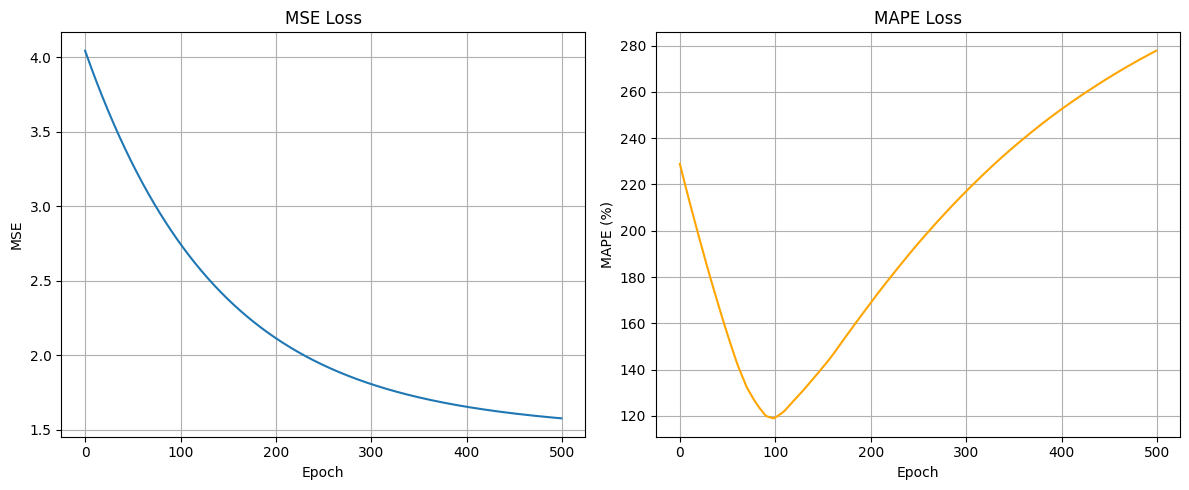

In [25]:
# 1. ANN 역전파 알고리즘 구현 및 평가 (numpy만 사용)
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
np.random.seed(0)
num_samples = 300
x1 = np.random.uniform(0, 1, num_samples)
x2 = np.random.uniform(0, 1, num_samples)
x3 = np.random.uniform(0, 1, num_samples)
y = 3 * x1 - 2 * x2 + x3

# bias 포함 입력 구성
X = np.stack([np.ones(num_samples), x1, x2, x3], axis=1)  # (300, 4)
y = y.reshape(-1, 1)

input_size = 4   # (bias+입력3개)
hidden_size = 4
output_size = 1
learning_rate = 0.001
epochs = 500

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

W1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size + 1, output_size)  # h0(bias)+h1~h4
b2 = np.zeros((1, output_size))

mse_list = []
mape_list = []

for epoch in range(epochs):
    Z1 = X @ W1 + b1
    H = sigmoid(Z1)
    H_bias = np.hstack([np.ones((num_samples, 1)), H])
    Z2 = H_bias @ W2 + b2
    y_pred = Z2

    error = y_pred - y
    mse = np.mean(error ** 2)
    mape = np.mean(np.abs(error / y)) * 100
    mse_list.append(mse)
    mape_list.append(mape)

    dZ2 = error
    dW2 = H_bias.T @ dZ2 / num_samples
    db2 = np.sum(dZ2, axis=0, keepdims=True) / num_samples

    dH = dZ2 @ W2[1:].T
    dZ1 = dH * sigmoid_derivative(Z1)
    dW1 = X.T @ dZ1 / num_samples
    db1 = np.sum(dZ1, axis=0, keepdims=True) / num_samples

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mse_list)
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('MSE Loss'); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(mape_list, color='orange')
plt.xlabel('Epoch'); plt.ylabel('MAPE (%)'); plt.title('MAPE Loss'); plt.grid(True)
plt.tight_layout()
plt.show()


2.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/25, Train Acc: 0.2422, Test Acc: 0.6469
Epoch 2/25, Train Acc: 0.6178, Test Acc: 0.7774
Epoch 3/25, Train Acc: 0.8178, Test Acc: 0.7982
Epoch 4/25, Train Acc: 0.8844, Test Acc: 0.8932
Epoch 5/25, Train Acc: 0.9256, Test Acc: 0.8932
Epoch 6/25, Train Acc: 0.9478, Test Acc: 0.9021
Epoch 7/25, Train Acc: 0.9711, Test Acc: 0.8783
Epoch 8/25, Train Acc: 0.9656, Test Acc: 0.9080
Epoch 9/25, Train Acc: 0.9800, Test Acc: 0.9347
Epoch 10/25, Train Acc: 0.9922, Test Acc: 0.9258
Epoch 11/25, Train Acc: 0.9933, Test Acc: 0.9169
Epoch 12/25, Train Acc: 0.9967, Test Acc: 0.9228
Epoch 13/25, Train Acc: 0.9944, Test Acc: 0.9199
Epoch 14/25, Train Acc: 0.9978, Test Acc: 0.9139
Epoch 15/25, Train Acc: 0.9956, Test Acc: 0.9377
Epoch 16/25, Train Acc: 0.9900, Test Acc: 0.9347
Epoch 17/25, Train Acc: 0.9967, Test Acc: 0.9318
Epoch 18/25, Train Acc: 1.0000, Test Acc: 0.925

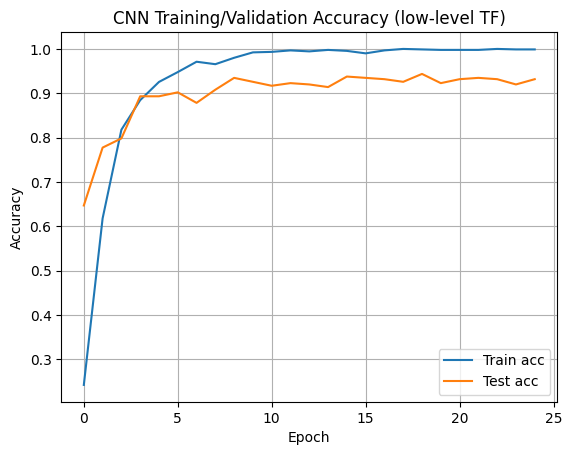


최종 Test Accuracy: 93.18%


In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 구글 드라이브에서 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

# 데이터 로드 및 정규화
train_x = np.load('/content/Finger_train_img.npy')
train_y = np.load('/content/Finger_train_label.npy')
test_x = np.load('/content/Finger_test_img.npy')
test_y = np.load('/content/Finger_test_label.npy')
train_x = train_x.astype(np.float32) / 255.0
test_x = test_x.astype(np.float32) / 255.0

# (흑백 이미지일 때) 채널 추가
if len(train_x.shape) == 3:
    train_x = train_x[..., np.newaxis]
    test_x = test_x[..., np.newaxis]

num_classes = 6
batch_size = 32
epochs = 25

# tf.data로 배치 묶기
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(1000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).batch(batch_size)

# CNN 직접 정의
class SimpleCNN(tf.Module):
    def __init__(self):
        super().__init__()
        # 첫번째 합성곱층(Conv2D)
        self.W1 = tf.Variable(tf.random.normal([3, 3, train_x.shape[3], 32], stddev=0.1))
        self.b1 = tf.Variable(tf.zeros([32]))
        # 두번째 합성곱층(Conv2D)
        self.W2 = tf.Variable(tf.random.normal([3, 3, 32, 64], stddev=0.1))
        self.b2 = tf.Variable(tf.zeros([64]))
        # 전결합층(Fully Connected)
        flatten_dim = (train_x.shape[1]//4) * (train_x.shape[2]//4) * 64
        self.W3 = tf.Variable(tf.random.normal([flatten_dim, 128], stddev=0.1))
        self.b3 = tf.Variable(tf.zeros([128]))
        self.W4 = tf.Variable(tf.random.normal([128, num_classes], stddev=0.1))
        self.b4 = tf.Variable(tf.zeros([num_classes]))

    def __call__(self, x, training=False):
        # 첫번째 합성곱+ReLU+MaxPooling
        x = tf.nn.conv2d(x, self.W1, strides=1, padding='SAME')
        x = tf.nn.bias_add(x, self.b1)
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
        # 두번째 합성곱+ReLU+MaxPooling
        x = tf.nn.conv2d(x, self.W2, strides=1, padding='SAME')
        x = tf.nn.bias_add(x, self.b2)
        x = tf.nn.relu(x)
        x = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='SAME')
        # 펼치기(Flatten)
        x = tf.reshape(x, [x.shape[0], -1])
        # 전결합+ReLU
        x = tf.matmul(x, self.W3) + self.b3
        x = tf.nn.relu(x)
        if training:
            x = tf.nn.dropout(x, rate=0.25)
        # 출력층(소프트맥스 전)
        logits = tf.matmul(x, self.W4) + self.b4
        return logits

# 모델 및 옵티마이저 준비
model = SimpleCNN()
optimizer = tf.optimizers.Adam()
train_acc_list, test_acc_list = [], []

# 학습 및 검증 루프
for epoch in range(epochs):
    epoch_loss = 0; correct = 0; total = 0
    for xb, yb in train_ds:
        with tf.GradientTape() as tape:
            logits = model(xb, training=True)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=yb, logits=logits))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss += loss.numpy() * xb.shape[0]
        pred = tf.argmax(logits, axis=1)
        true = tf.argmax(yb, axis=1)
        correct += np.sum(pred.numpy() == true.numpy())
        total += xb.shape[0]
    train_acc = correct / total
    train_acc_list.append(train_acc)
    # 검증 (test set)
    correct = 0; total = 0
    for xb, yb in test_ds:
        logits = model(xb, training=False)
        pred = tf.argmax(logits, axis=1)
        true = tf.argmax(yb, axis=1)
        correct += np.sum(pred.numpy() == true.numpy())
        total += xb.shape[0]
    test_acc = correct / total
    test_acc_list.append(test_acc)
    print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# 학습/검증 정확도 곡선
plt.plot(train_acc_list, label='Train acc')
plt.plot(test_acc_list, label='Test acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.title('CNN Training/Validation Accuracy (low-level TF)')
plt.show()

# 최종 정확도 출력
print(f"\n최종 Test Accuracy: {test_acc_list[-1]*100:.2f}%")



3.

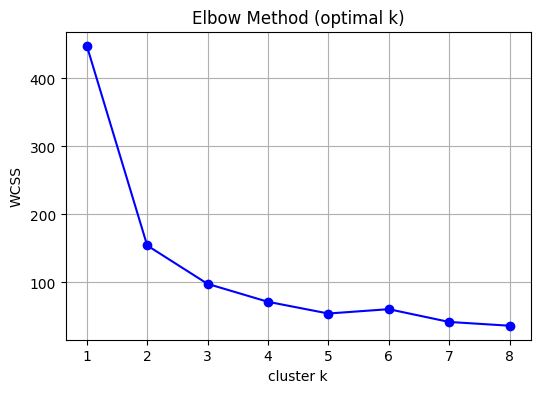

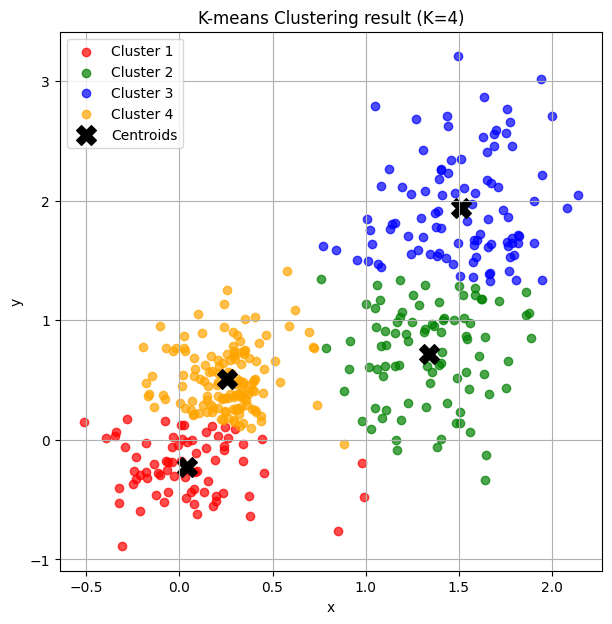

In [16]:
# 3. K-평균 클러스터링 (numpy만 사용)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
data1 = np.array((np.random.normal(0, 0.2, 100), np.random.normal(0.0, 0.4, 100)))
data2 = np.array((np.random.normal(1.2, 0.3, 100), np.random.normal(1.1, 0.7, 100)))
data3 = np.array((np.random.normal(1.6, 0.2, 100), np.random.normal(1.8, 0.7, 100)))
data4 = np.array((np.random.normal(0.3, 0.1, 100), np.random.normal(0.5, 0.3, 100)))

# 2차원 데이터 합치기 (총 400 x 2)
all_data = np.hstack([data1, data2, data3, data4]).T

# 각 그룹별 평균(센트로이드 초기값)
means = []
for d in [data1, data2, data3, data4]:
    mx = np.mean(d[0])
    my = np.mean(d[1])
    means.append([mx, my])
means = np.array(means)

# numpy만 써서 K-means 직접 구현
def my_kmeans(X, K, init_centroids=None, max_iter=100):
    N = X.shape[0]
    if init_centroids is not None:
        centroids = init_centroids.copy()
    else:
        idx = np.random.choice(N, K, replace=False)
        centroids = X[idx]
    for epoch in range(max_iter):
        # 각 점과 센트로이드 거리 구하기
        dists = []
        for c in centroids:
            dists.append(np.sqrt(np.sum((X - c)**2, axis=1)))
        dists = np.stack(dists, axis=1)  # (N, K)
        # 가장 가까운 센트로이드 찾기
        labels = np.argmin(dists, axis=1)
        # 새 센트로이드 구하기
        new_centroids = []
        for k in range(K):
            members = X[labels == k]
            if len(members) == 0:
                new_centroids.append(centroids[k])
            else:
                new_centroids.append(np.mean(members, axis=0))
        new_centroids = np.array(new_centroids)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids
    # WCSS(군집내 거리 제곱합)
    wcss = 0
    for k in range(K):
        members = X[labels == k]
        if len(members) > 0:
            wcss += ((members - centroids[k])**2).sum()
    return labels, centroids, wcss

# Elbow method: 여러 K에 대해 WCSS 저장
K_list = list(range(1, 9))
wcss_list = []
for K in K_list:
    if K == 4:
        _, _, wcss = my_kmeans(all_data, K, init_centroids=means)
    else:
        _, _, wcss = my_kmeans(all_data, K)
    wcss_list.append(wcss)

# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(K_list, wcss_list, 'o-', color='blue')
plt.xlabel('cluster k')
plt.ylabel('WCSS')
plt.title('Elbow Method (optimal k)')
plt.grid(True)
plt.show()

# K=4로 클러스터링 & 시각화
labels, centroids, _ = my_kmeans(all_data, 4, init_centroids=means)
plt.figure(figsize=(7,7))
colors = ['red', 'green', 'blue', 'orange']
for k in range(4):
    plt.scatter(all_data[labels==k,0], all_data[labels==k,1], c=colors[k], label=f'Cluster {k+1}', alpha=0.7)
plt.scatter(centroids[:,0], centroids[:,1], s=200, c='black', marker='X', label='Centroids')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-means Clustering result (K=4)')
plt.legend()
plt.grid(True)
plt.show()
